In [215]:
from torchvision import models

In [219]:
models.vgg19()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm

from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from torchvision.transforms import Compose, Resize, Normalize, ToTensor, RandomCrop, RandomHorizontalFlip
from torchvision.datasets import CIFAR10, STL10, ImageFolder

In [2]:
sys.path.insert(0, '/home/brendalf/Documents/projects/gan-attack/src')

In [3]:
from models.vgg import VGG

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:
target = torch.load('../models/target/cifar10.vgg19.pth')
#target = target.to(torch.device('cpu'))
target = target.to(DEVICE)

In [74]:
#target

In [75]:
# Freeze model weights
for param in target.parameters():
    param.requires_grad = False

In [76]:
global tipo

In [77]:
def hook(module, input, output):
    output = output.view(64, -1).cpu()
    if tipo == "odd":
        odd_raw.extend(np.array(output))
    elif tipo == "pdd":
        pdd_raw.extend(np.array(output))
    elif tipo == "gan":
        gan_raw.extend(np.array(output))

In [78]:
target.module.features[53].register_forward_hook(hook)

In [79]:
oddset = CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),     
    ])
)

Files already downloaded and verified


In [80]:
oddloader = DataLoader(
    oddset, batch_size=64, shuffle=False, num_workers=2, drop_last=True
)

In [81]:
tipo = "odd"
odd_raw = []
odd_outputs = []

for img, lbl in tqdm(oddloader):
    img = img.to(DEVICE)
    
    out = target(img)
    _, pred = out.max(1)
    odd_outputs.extend(pred.cpu())

100%|██████████| 156/156 [00:02<00:00, 69.18it/s]


In [82]:
odd_outputs = [x.item() for x in odd_outputs]

In [83]:
del oddset, oddloader

In [84]:
odd = pd.DataFrame(odd_raw)
odd['type'] = tipo
odd['y'] = odd_outputs
odd.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,type,y
0,0.011381,0.000812,0.007693,0.061440,0.884891,0.0,0.0,0.006004,0.000000,0.776068,...,0.000000,0.000000,0.000000,0.635993,0.000074,0.772568,0.000000,0.000000,odd,3
1,0.208930,0.000000,0.000893,0.000000,0.008300,0.0,0.0,0.000000,0.040637,0.000000,...,0.005354,0.257556,0.096137,0.042342,0.000000,0.213609,0.014963,0.000000,odd,8
2,0.162913,0.000000,0.007206,0.000000,0.000000,0.0,0.0,0.000000,0.039107,0.000000,...,0.008664,0.383878,0.249772,0.258908,0.000000,0.057884,0.093183,0.000000,odd,8
3,0.019950,0.039474,0.001610,0.000000,0.086252,0.0,0.0,0.000000,0.126647,0.081427,...,0.041173,0.381322,0.100545,0.316355,0.000917,0.000000,0.219249,0.117474,odd,0
4,0.000000,0.000000,0.018516,0.014238,0.000000,0.0,0.0,0.078603,0.086412,0.000000,...,0.216549,0.000000,0.079884,0.344690,0.002245,0.438257,0.018812,0.000000,odd,6


In [85]:
pddset = ImageFolder(
    root='../data/dataset_i',
    transform=Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),     
    ])
)

In [86]:
pddloader = DataLoader(
    pddset, batch_size=64, shuffle=False, num_workers=2, drop_last=True
)

In [87]:
tipo = "pdd"
pdd_raw = []
pdd_outputs = []

for img, lbl in tqdm(pddloader):
    img = img.to(DEVICE)
    
    out = target(img)
    _, pred = out.max(1)
    pdd_outputs.extend(pred.cpu())

100%|██████████| 78/78 [00:01<00:00, 66.06it/s]


In [88]:
pdd_outputs = [x.item() for x in pdd_outputs]

In [89]:
del pddset, pddloader

In [90]:
pdd = pd.DataFrame(pdd_raw)
pdd['type'] = tipo
pdd['y'] = pdd_outputs
pdd.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,type,y
0,0.000000,0.130425,0.010752,0.051879,0.378613,0.0,0.0,0.072886,0.000000,0.283283,...,0.036080,0.015520,0.000000,0.220755,0.000914,0.600466,0.000388,0.686074,pdd,9
1,0.000000,0.259720,0.010698,0.019266,0.962606,0.0,0.0,0.750068,0.000000,0.900148,...,0.000000,0.022154,0.117149,0.391219,0.000000,0.208298,0.000000,0.000000,pdd,5
2,0.110950,0.039852,0.003997,0.000000,0.034916,0.0,0.0,0.483368,0.034229,0.399299,...,0.116447,0.130998,0.242678,0.377106,0.001974,0.028075,0.106729,0.000000,pdd,0
3,0.096665,0.000000,0.000664,0.000000,0.033111,0.0,0.0,0.025885,0.093603,0.000000,...,0.021429,0.317515,0.131973,0.235742,0.000696,0.000000,0.201079,0.087234,pdd,0
4,0.042058,0.000000,0.009351,0.000000,0.050111,0.0,0.0,0.111949,0.000000,0.442346,...,0.239052,0.041236,0.314665,0.007297,0.004388,0.027990,0.033781,0.000000,pdd,4


In [91]:
ganset = ImageFolder(
    root='../data/dataset_gan113',
    transform=Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),     
    ])
)

In [92]:
ganloader = DataLoader(
    ganset, batch_size=64, shuffle=False, num_workers=2, drop_last=True
)

In [93]:
tipo = "gan"
gan_raw = []
gan_outputs = []

for img, lbl in tqdm(ganloader):
    img = img.to(DEVICE)
    
    out = target(img)
    _, pred = out.max(1)
    gan_outputs.extend(pred.cpu())

100%|██████████| 1484/1484 [00:20<00:00, 72.41it/s]


In [94]:
gan_outputs = [x.item() for x in gan_outputs]

In [95]:
del ganset, ganloader

In [96]:
gan = pd.DataFrame(gan_raw)
gan['type'] = tipo
gan['y'] = gan_outputs
gan.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,type,y
0,0.016900,0.135838,0.011829,0.030187,0.031030,0.0,0.0,0.537192,0.000000,0.126222,...,0.016085,0.000000,0.043918,0.029038,0.000692,0.298752,0.043049,1.009365,gan,9
1,0.041754,0.000000,0.004295,0.000000,0.028214,0.0,0.0,0.000000,0.107866,0.000000,...,0.068201,0.377212,0.154908,0.468146,0.001025,0.000000,0.232335,0.080653,gan,0
2,0.105039,0.000000,0.002113,0.000000,0.034167,0.0,0.0,0.287200,0.094178,0.187728,...,0.073134,0.155296,0.149760,0.265918,0.001334,0.001939,0.131240,0.000000,gan,0
3,0.112301,0.000000,0.004750,0.000000,0.035029,0.0,0.0,0.187719,0.060342,0.297310,...,0.121908,0.107978,0.250715,0.258667,0.002008,0.000000,0.145746,0.000000,gan,0
4,0.034942,0.036191,0.016130,0.009888,0.036884,0.0,0.0,0.030243,0.000000,0.194436,...,0.001814,0.390134,0.322420,0.303692,0.000210,0.030099,0.121476,0.486301,gan,1


In [97]:
del target

In [98]:
def preprocess(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

In [99]:
scaler = StandardScaler()

In [100]:
columns = [x for x in range(512)]
#columns

In [101]:
scaler.fit(odd[columns])
odd[columns] = scaler.transform(odd[columns])
pdd[columns] = scaler.transform(pdd[columns])
gan[columns] = scaler.transform(gan[columns])

In [42]:
#odd[columns] = preprocess(odd[columns])
#pdd[columns] = preprocess(pdd[columns])

In [102]:
df = []

for c in range(10):
    for d in [odd, pdd, gan]: 
        idx = d.query(f"y == {c}").index.tolist()
        idx_choosen = np.random.choice(idx, 100)
        df.append(d.loc[idx_choosen])

In [103]:
df = pd.concat(df)

In [104]:
df.y.value_counts()

9    300
7    300
5    300
3    300
1    300
8    300
6    300
4    300
2    300
0    300
Name: y, dtype: int64

In [105]:
df.type.value_counts()

pdd    1000
odd    1000
gan    1000
Name: type, dtype: int64

In [106]:
X = df[columns]
y = df.y

In [107]:
tsne = TSNE(n_components=2, perplexity=30, verbose=1, n_iter=5000, learning_rate=100)

In [108]:
emb = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.106s...
[t-SNE] Computed neighbors for 3000 samples in 4.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.387959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.383858
[t-SNE] KL divergence after 5000 iterations: 0.983139


In [109]:
emb

array([[ -6.7431173 ,  19.01455   ],
       [ -0.83024186,  18.92143   ],
       [ -8.545312  ,  11.99976   ],
       ...,
       [-51.452496  , -34.47115   ],
       [-52.86218   , -27.493942  ],
       [-60.031246  , -51.951557  ]], dtype=float32)

In [110]:
df['tsne_x'] = 0
df['tsne_y'] = 0

df[['tsne_x', 'tsne_y']] = emb

In [114]:
colors = {
    'odd': ['#ec5bea', '#dddf1e', '#06c606', '#62696e', '#e71f24', '#5054fd', '#87f587', '#fb9d16', '#ffd2d9', '#05f7fa'],
    'pdd': ['#bf00bf', '#bfbf00', '#008000', '#121212', '#a80b0f', '#0000ff', '#00ff00', '#da8409', '#ffc0cb', '#00bfbf'],
    'gan': ['#bf00bf', '#bfbf00', '#008000', '#121212', '#a80b0f', '#0000ff', '#00ff00', '#da8409', '#ffc0cb', '#00bfbf']
}

markers = {
    'odd': '.',
    'pdd': 'x',
    'gan': 'x'
}

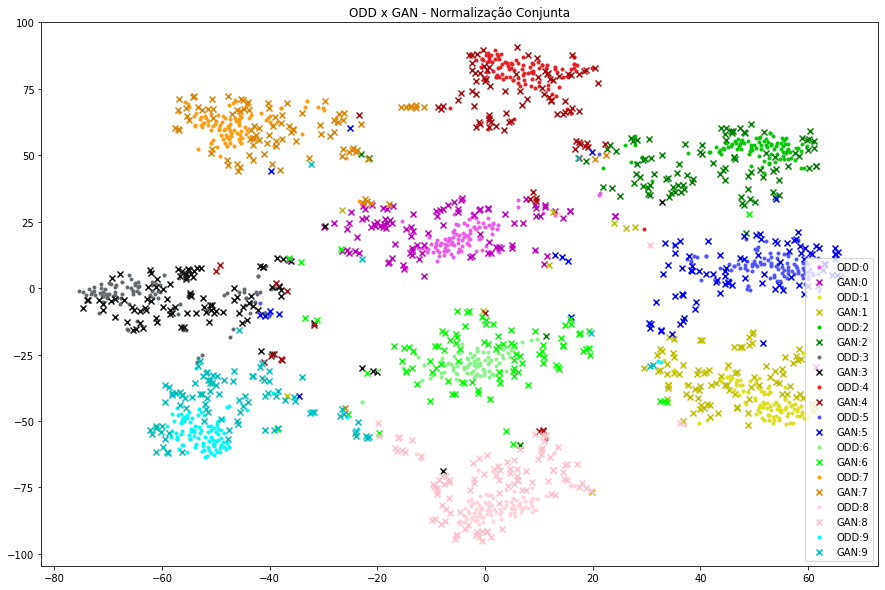

In [120]:
plt.figure(figsize=[15, 10])

for c in range(10):
    for t in ['odd', 'gan']:
        plt.scatter(
            df.query(f"type == '{t}' and y == {c}").tsne_x, 
            df.query(f"type == '{t}' and y == {c}").tsne_y,
            c=colors[t][c],
            marker=markers[t],
        )
        
plt.title('ODD x GAN - Normalização Conjunta')
plt.legend([f"{t}:{c}" for c in range(10) for t in ['ODD', 'GAN']])
plt.savefig('../logs/tsne/ODDxGAN (cifar_test+dataset_gan113).svg')

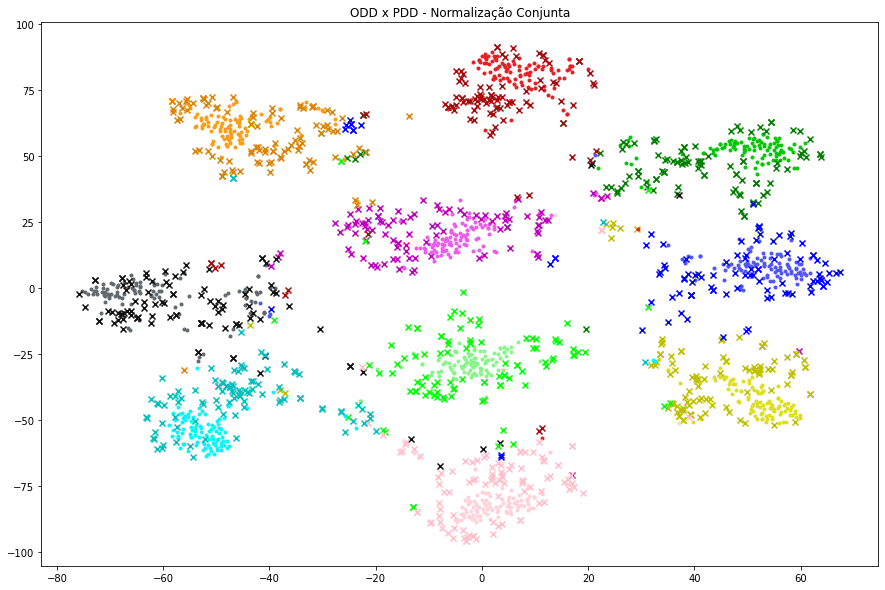

In [119]:
plt.figure(figsize=[15, 10])

for c in range(10):
    for t in ['odd', 'pdd']:
        plt.scatter(
            df.query(f"type == '{t}' and y == {c}").tsne_x, 
            df.query(f"type == '{t}' and y == {c}").tsne_y,
            c=colors[t][c],
            marker=markers[t],
        )
        
plt.title('ODD x PDD - Normalização Conjunta')
plt.savefig('../logs/tsne/ODDxPDD (cifar_test+dataset_i).svg')